### Linear model


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'a_mean_age':                  'int8',
 'a_std_age':                   'float16',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int32',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int32',
 'perceived_colour_value_id':   'int32',
 'perceived_colour_master_id':  'int32',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'is_for_male':                 'bool',
 'is_for_female':               'bool',
 'is_for_mama':                 'bool',
 'c_mean_price':                'float16',
 'c_std_price':                 'float16',
 'a_mean_price':                'float16',     
 'c_cv_total':                  'int32',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'a_cv_recent_on':              'int32',
 'a_cv_recent_off':             'int32',
 'a_cv_recent2':                'int32',
 'a_cv_recent_ratio':           'float16',
 'a_cv_recent_ranking':         'int16',
 'a_cv_recent_ranking2':        'int16',
 'c_mean_sales_channel_id':     'float16',
 'a_mean_sales_channel_id':     'float16',
 'c_mean_is_for_male':          'float16',
 'a_mean_is_for_male':          'float16',
 'c_mean_is_for_female':        'float16',
 'a_mean_is_for_female':        'float16',
 'c_mean_is_for_mama':          'float16',
 'diff_dat_last_buy':           'int16',
 'a_mean_is_for_mama':          'float16',
 'ca_index_group_no_num':       'int32',
 'index_group_no_similarity':   'float32',
 'ca_index_code_num':           'int32',
 'index_code_similarity':       'float32',
 'ca_product_group_no_num':     'int32',
 'product_group_no_similarity': 'float32',
 'buy_same_before':             'int16',
 'buy_same_before_recent':      'int16',
 'buy_same_last_week':          'int16',
 'buy_rank1_before':             'int16',
 'buy_rank2_before':             'int16',
 'diff_dat_last_buy_rank1':      'int16',
 'diff_dat_last_buy_rank2':      'int16',
 'delta_mean_price':            'float16',
 'delta_mean_age':              'int8',
 'delta_mean_sales_channel_id': 'float16',
 'delta_mean_is_for_male':      'float16',
 'delta_mean_is_for_female':    'float16',
 'delta_mean_is_for_mama':      'float16',
 'match_rank':                  'int8',
 'als_rank':                    'int8',
 'match_len':                   'int8'
 }

In [4]:
# train data
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09']
#train_date_list = ['2020-09-09', '2020-09-16']
train_date_list = ['2020-09-09']
#train_date_list = ['2020-09-16']
train_list = [dd.read_csv(f'./train_{date}.csv', dtype=input_type).compute() for date in train_date_list]

In [5]:
train = pd.concat([train_list[0]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
#valid = train_list[3].reset_index(drop=True)

In [6]:
# 毎回同じbaselineと比較するため固定
valid = dd.read_csv(f'./train_2020-09-16.csv', dtype=input_type).compute() 
#valid = dd.read_csv(f'./train_2020-09-09.csv', dtype=input_type).compute() 
valid = valid.reset_index(drop=True)

In [7]:
train

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-4617291842348727650,8,559616013,0,99,False,True,True,0,4,...,-0.001149,-11,0.248047,0.0,0.0,0.0,1,0,104,999
1,-4617291842348727650,8,590928001,1,99,False,True,True,0,4,...,-0.006222,-10,-0.305664,0.0,0.0,0.0,1,0,104,999
2,-4617291842348727650,8,712924012,2,99,False,True,True,0,4,...,0.006569,-10,-0.314453,0.0,0.0,0.0,0,0,999,999
3,-4617291842348727650,8,879944002,3,99,False,True,True,0,4,...,0.006569,-10,0.666992,0.0,0.0,0.0,0,1,999,104
4,-4617291842348727650,8,566140001,4,99,False,True,True,0,4,...,0.007927,-12,-0.035156,0.0,0.0,0.0,1,0,104,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880755,-2661682485847144637,0,781613006,35,99,False,True,True,0,4,...,-0.047974,-11,-1.981445,0.0,-1.0,0.0,0,0,999,999
2880756,-2661682485847144637,0,759814009,36,99,False,True,True,0,4,...,-0.032410,-10,-1.939453,0.0,-1.0,0.0,0,0,999,999
2880757,-2661682485847144637,0,850917001,37,99,False,True,True,0,4,...,-0.024429,-15,-1.780273,0.0,-1.0,0.0,0,0,999,999
2880758,-2661682485847144637,0,158340001,38,99,False,True,True,0,4,...,-0.012299,-10,-1.321289,0.0,-1.0,0.0,0,0,999,999


In [8]:
train.columns.values

array(['customer_id', 'match_len', 'article_id', 'match_rank', 'als_rank',
       'label', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'c_mean_price',
       'c_std_price', 'c_cv_total', 'c_cv_recent',
       'c_mean_sales_channel_id', 'c_mean_is_for_male',
       'c_mean_is_for_female', 'c_mean_is_for_mama', 'diff_dat_last_buy',
       'product_code', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'is_for_male',
       'is_for_female', 'is_for_mama', 'product_group_no', 'a_mean_price',
       'a_cv_total', 'a_cv_recent', 'a_cv_recent_on', 'a_cv_recent_off',
       'a_cv_recent2', 'a_cv_recent_ranking', 'a_cv_recent_ranking2',
       'a_cv_recent_ratio', 'a_mean_sales_channel_id', 'a_mean_age',
       'a_std_age', 'ca_index_group_no_num', 'index_group_no_sim

In [9]:
valid

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-216791697895142778,10,859105002,0,99,False,False,False,0,2,...,0.010979,-4,0.081055,0.111084,-0.111328,0.0,1,0,78,999
1,-216791697895142778,10,859105009,1,99,False,False,False,0,2,...,0.010094,-1,-0.043945,0.111084,-0.111328,0.0,0,0,999,999
2,-216791697895142778,10,859105004,2,99,False,False,False,0,2,...,0.011894,-2,0.066406,0.111084,-0.111328,0.0,0,0,999,999
3,-216791697895142778,10,859105006,3,99,False,False,False,0,2,...,0.010666,-4,0.146484,0.111084,-0.111328,0.0,7,0,78,999
4,-216791697895142778,10,811907011,4,99,False,False,False,0,2,...,0.006935,0,-0.258789,0.111084,-0.111328,0.0,1,0,81,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759355,-8747047206777816159,0,841383002,35,99,False,False,False,0,2,...,-0.008110,-4,-1.806641,0.000000,-1.000000,0.0,0,0,999,999
2759356,-8747047206777816159,0,894780001,36,99,False,False,False,0,2,...,-0.033539,-3,-2.000000,0.000000,-1.000000,0.0,0,0,999,999
2759357,-8747047206777816159,0,706016001,37,99,False,False,False,0,2,...,-0.032440,0,-1.845703,0.000000,-1.000000,0.0,0,0,999,999
2759358,-8747047206777816159,0,936622001,38,99,False,False,False,0,2,...,-0.025070,-5,-2.000000,0.000000,-1.000000,0.0,0,0,999,999


In [10]:
del train_list
gc.collect()

0

In [11]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-4617291842348727650,8,559616013,0,99,False,True,True,0,4,...,-0.001149,-11,0.248047,0.0,0.0,0.0,1,0,104,999
1,-4617291842348727650,8,590928001,1,99,False,True,True,0,4,...,-0.006222,-10,-0.305664,0.0,0.0,0.0,1,0,104,999
2,-4617291842348727650,8,712924012,2,99,False,True,True,0,4,...,0.006569,-10,-0.314453,0.0,0.0,0.0,0,0,999,999
3,-4617291842348727650,8,879944002,3,99,False,True,True,0,4,...,0.006569,-10,0.666992,0.0,0.0,0.0,0,1,999,104
4,-4617291842348727650,8,566140001,4,99,False,True,True,0,4,...,0.007927,-12,-0.035156,0.0,0.0,0.0,1,0,104,999


## Apply Linear model

In [12]:
# -----------------------------------
# 線形モデルの実装
# -----------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

In [13]:
# とりあえず0埋め
train = train.fillna(0)
valid = valid.fillna(0)

In [14]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [15]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

In [16]:
# データのスケーリング
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [18]:
# 線形モデルの構築・学習
max_logloss = 0
max_auc = 0
valid_yl = list(valid_y)

#for c in [0.0001, 0.001]:
#    #model = LogisticRegression(C=1.0)
#    model = LogisticRegression(C=c)
#    model.fit(train_x, train_y)
#    valid_pred = model.predict_proba(valid_x)
#    score = log_loss(valid_y, valid_pred)
#    
#    auc = roc_auc_score(valid_yl, valid_pred[:, 1])
#    print(f'logloss: {score:.4f}')
#    print("AUC: {}".format(auc))
#    
#    if score > max_logloss:
#        print('logloss update, c=', c)
#        max_logloss = score
#    if auc > max_auc:
#        print('auc update, auc=', auc)
#        max_auc = auc

In [19]:
model = LogisticRegression(C=0.001, class_weight='balanced')
model.fit(train_x, train_y)
valid_pred = model.predict_proba(valid_x)
score = log_loss(valid_y, valid_pred)

auc = roc_auc_score(valid_yl, valid_pred[:, 1])
print(f'logloss: {score:.4f}')
print("AUC: {}".format(auc))

logloss: 0.5383
AUC: 0.7050006663792078


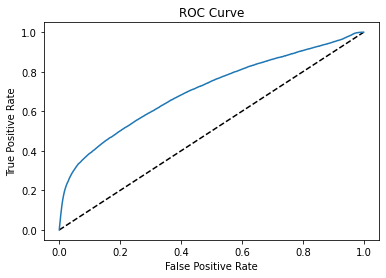

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC曲線の値の生成：fpr、tpr、閾値
fpr, tpr, thresholds = roc_curve(valid_yl, valid_pred[:, 1])

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [22]:
# save as meta feature
valid_pred[:,1]

array([0.83114748, 0.57509325, 0.2247933 , ..., 0.26247398, 0.24321791,
       0.45241253])

## test

In [21]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

3008

In [22]:
# test data
#Nval = 12
test = dd.read_csv(f'./test.csv', dtype=input_type).compute()
#test = dd.read_csv(f'./test_2020-09-16.csv', dtype=input_type).compute()
test.sort_index(inplace=True)
test = test.fillna(0)
test

,customer_id,match_len,article_id,match_rank,als_rank,FN,Active,club_member_status,fashion_news_frequency,age,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-5449466430634306129,7,749699002,0,99,False,False,0,2,24,...,-0.002726,-9,-0.153320,0.0,0.0,0.0,0,0,999,999
0,6211733102869751205,6,918522001,10,99,True,True,0,4,20,...,-0.024048,-15,-0.158203,0.0,0.0,0.0,0,0,999,999
0,-398316065214153929,3,924243001,9,99,False,False,0,2,23,...,-0.010422,-12,0.379883,0.0,0.0,0.0,0,0,999,999
0,8541635545749385918,3,915529003,39,99,True,True,0,4,21,...,-0.005058,-14,-0.553711,0.0,0.0,0.0,0,0,999,999
0,-4236472338739829826,4,912579002,0,99,True,True,0,4,21,...,-0.008759,-12,-0.142578,0.0,0.0,0.0,0,0,999,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111714,1254218249113875981,5,896169005,21,99,False,False,0,2,24,...,-0.011742,-10,0.003906,0.0,0.0,0.0,0,0,999,999
111715,1254218249113875981,5,850917001,22,99,False,False,0,2,24,...,0.013901,-12,0.217773,0.0,0.0,0.0,0,0,999,999
111716,1254218249113875981,5,761406001,23,99,False,False,0,2,24,...,0.015518,-8,0.263672,0.0,0.0,0.0,0,0,999,999
111717,1254218249113875981,5,926502001,24,99,False,False,0,2,24,...,-0.019577,-6,0.441406,0.0,0.0,0.0,0,0,999,999


In [23]:
Nrow = 25000000
test1 = test.iloc[:Nrow,:]
test2 = test.iloc[Nrow:,:]

In [24]:
del test
gc.collect()

0

In [25]:
test_id1 = test1[['customer_id', 'article_id']]
test1 = test1.drop(['customer_id', 'article_id'], axis=1)

test_id2 = test2[['customer_id', 'article_id']]
test2 = test2.drop(['customer_id', 'article_id'], axis=1)

In [26]:
test1 = scaler.transform(test1)
test2 = scaler.transform(test2)

In [27]:
pred1 = model.predict_proba(test1)
del test1
gc.collect()

0

In [28]:
pred2 = model.predict_proba(test2)
del test2
gc.collect()

0

In [29]:
test_id = pd.concat([test_id1, test_id2])
pred = np.concatenate([pred1, pred2])

In [30]:
pred = pred[:,1]

In [31]:
pred.mean()

0.3628018025409945

In [32]:
pred

array([0.8676692 , 0.40337855, 0.55148336, ..., 0.42227295, 0.34761032,
       0.50310762])

In [33]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [34]:
sub1 = pd.concat([test_id, pred], axis=1)

In [35]:
sub1

,customer_id,article_id,score
0,-5449466430634306129,749699002,0.867669
1,6211733102869751205,918522001,0.403379
2,-398316065214153929,924243001,0.551483
3,8541635545749385918,915529003,0.280272
4,-4236472338739829826,912579002,0.891394
...,...,...,...
54879195,1254218249113875981,896169005,0.338055
54879196,1254218249113875981,850917001,0.319809
54879197,1254218249113875981,761406001,0.422273
54879198,1254218249113875981,926502001,0.347610


In [36]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [37]:
sub1['score']

33650989    0.852756
33652160    0.821819
33660320    0.596747
33664189    0.452851
33651210    0.418266
              ...   
27344456    0.211192
27342565    0.202013
27348090    0.190703
27353200    0.174432
27353915    0.171452
Name: score, Length: 54879200, dtype: float64

In [38]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [39]:
sub1['prediction'].apply(len)

0          40
1          40
2          40
3          40
4          40
           ..
1371975    40
1371976    40
1371977    40
1371978    40
1371979    40
Name: prediction, Length: 1371980, dtype: int64

In [40]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0          12
1          12
2          12
3          12
4          12
           ..
1371975    12
1371976    12
1371977    12
1371978    12
1371979    12
Name: prediction, Length: 1371980, dtype: int64

In [41]:
sub1['prediction']

0          [706016001, 706016002, 871710001, 714790020, 7...
1          [908292002, 910601003, 910601003, 903926002, 8...
2          [751471043, 896152002, 918522001, 924243001, 7...
3          [809238005, 568601006, 706016001, 915526001, 4...
4          [751471043, 751471001, 910601003, 896152002, 7...
                                 ...                        
1371975    [809238005, 706016001, 448509014, 918292001, 7...
1371976    [658030020, 714790020, 658030011, 706016001, 6...
1371977    [809238005, 448509014, 915529003, 751471001, 8...
1371978    [565379022, 896152002, 918522001, 924243001, 7...
1371979    [781758003, 781758001, 809238005, 918292001, 6...
Name: prediction, Length: 1371980, dtype: object

In [42]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [43]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0706016002 0871710001 0714790020 07...
1,-9223343869995384291,0908292002 0910601003 0910601003 0903926002 08...
2,-9223321797620987725,0751471043 0896152002 0918522001 0924243001 07...
3,-9223319430705797669,0809238005 0568601006 0706016001 0915526001 04...
4,-9223308614576639426,0751471043 0751471001 0910601003 0896152002 07...
...,...,...
1371975,9223319300843860958,0809238005 0706016001 0448509014 0918292001 07...
1371976,9223333063893176977,0658030020 0714790020 0658030011 0706016001 06...
1371977,9223345314868180224,0809238005 0448509014 0915529003 0751471001 08...
1371978,9223357421094039679,0565379022 0896152002 0918522001 0924243001 07...


## Submit

In [44]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [45]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [46]:
print(sub.shape, sub1.shape)

(1371980, 2) (1371980, 2)


In [47]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [48]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0706016002 0871710001 0714790020 07...
1,-9223343869995384291,0908292002 0910601003 0910601003 0903926002 08...
2,-9223321797620987725,0751471043 0896152002 0918522001 0924243001 07...
3,-9223319430705797669,0809238005 0568601006 0706016001 0915526001 04...
4,-9223308614576639426,0751471043 0751471001 0910601003 0896152002 07...
...,...,...
1371975,9223319300843860958,0809238005 0706016001 0448509014 0918292001 07...
1371976,9223333063893176977,0658030020 0714790020 0658030011 0706016001 06...
1371977,9223345314868180224,0809238005 0448509014 0915529003 0751471001 08...
1371978,9223357421094039679,0565379022 0896152002 0918522001 0924243001 07...


In [49]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [50]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [51]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0568601043 0762846027 0751471001 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0809238005 0915526001 0706016001 0706016001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0805000001 0809238005 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0730683001 0720125001 0372860001 0751471043 05...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0896152002 0791587015 0896152001 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0372860001 0611415001 0804992014 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846008 0762846031 0809238005 0759871002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846027 0762846031 0809238005 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0809238005 0448509014 0706016001 0918292001 03...


In [52]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission_linear_test.csv', index=False)

(1371980, 2)
